In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from importlib import reload  
%matplotlib notebook

In [2]:
def dxx(T,h):
    return np.concatenate((np.array([0.0]),(1.0/(h**2))*(T[2:]-2.0*T[1:-1]+T[:-2]),np.array([0.0])))

In [3]:
def dt(T,h):
    return dxx(T,h)

<IPython.core.display.Javascript object>


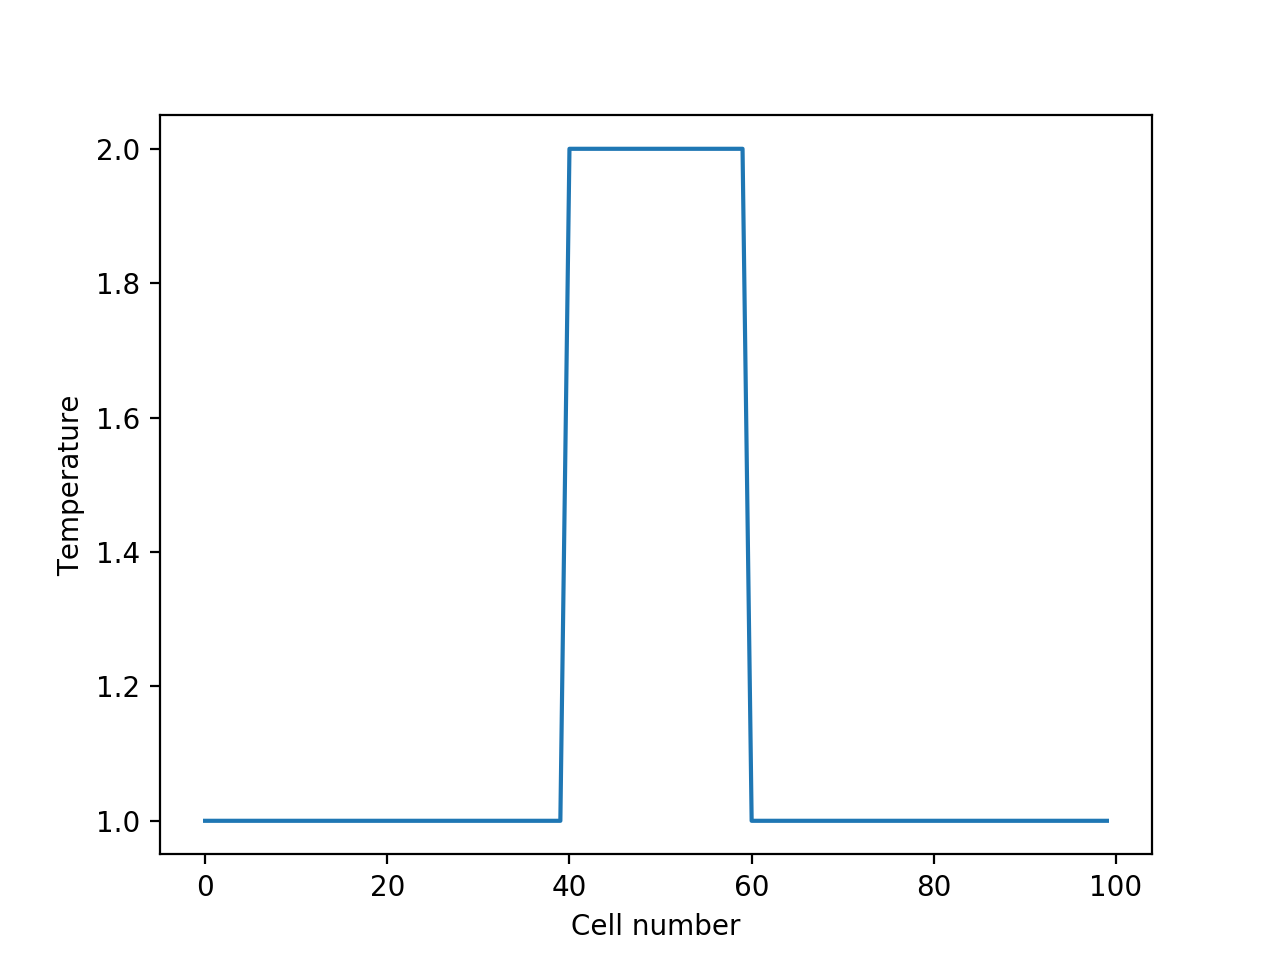

In [4]:
T0=np.ones(100)
T0[40:60]*=2.0
h=0.1
plt.figure()
plt.plot(T0)
plt.xlabel("Cell number")
plt.ylabel("Temperature")
plt.show()

In [5]:
t=0.0001*np.linspace(0,1000,1000)

In [6]:
def solve(T0,times):
    T=[T0]
    tau=0.0001
    for i in range(len(times)-1):
        TSol=T[-1]+tau*dt(T[-1],h)
        T.append(TSol)
    T=np.stack(T, axis=0)
    return T

In [8]:
%timeit -n 1 -r 1 solve(T0,t)
T=solve(T0,t)

15.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
x,tm = np.meshgrid(h*np.linspace(0,100,100),t)

<IPython.core.display.Javascript object>


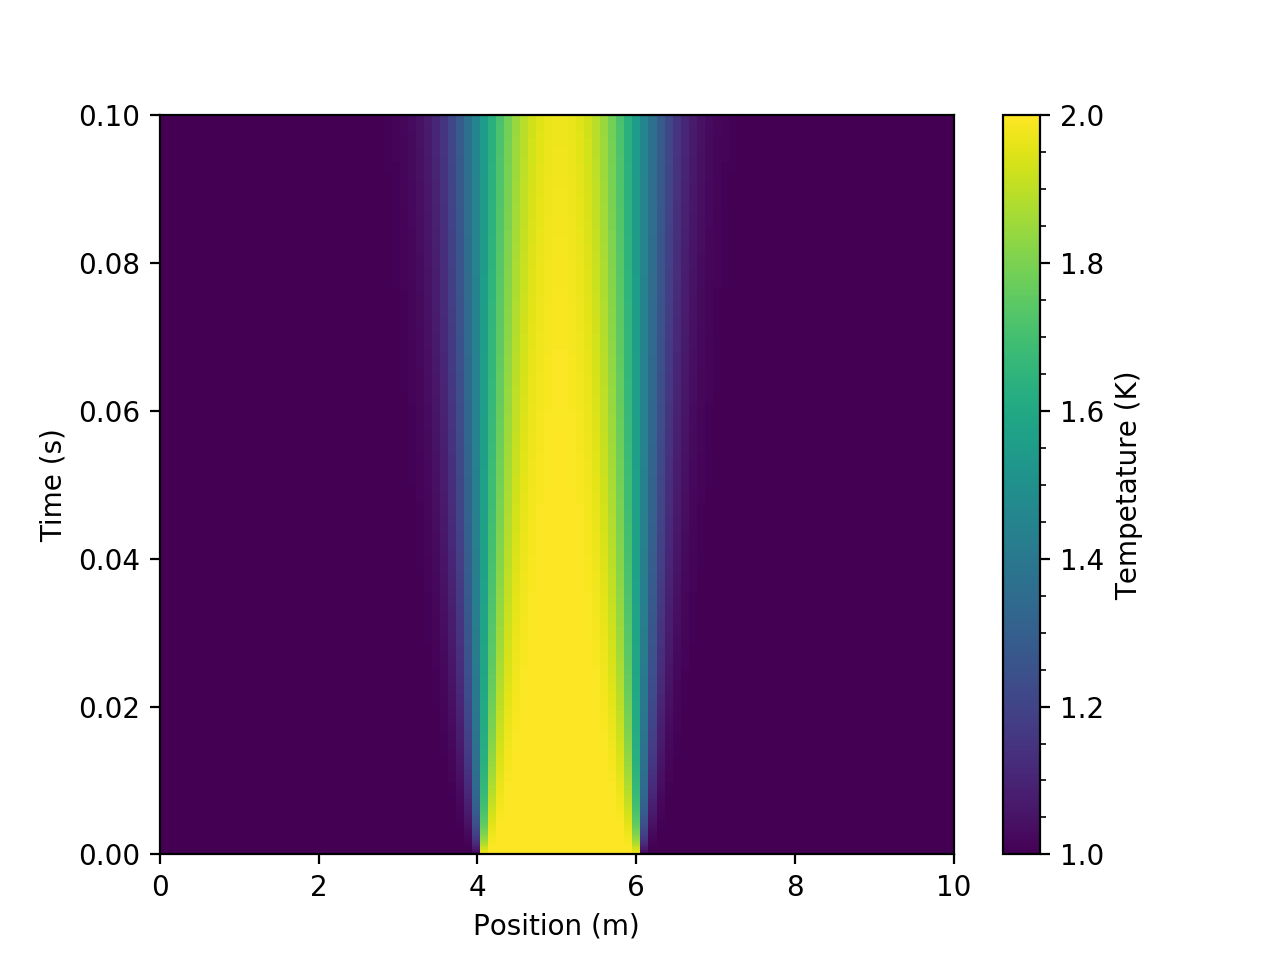

In [10]:
fig = plt.figure()
plt.pcolormesh(x,tm,T)
plt.xlabel("Position (m)")
plt.ylabel("Time (s)")
cbar = plt.colorbar()
cbar.minorticks_on()
cbar.set_label("Tempetature (K)")
plt.show()

## An object structure for the 1D heat equation

To build a simple oobject structure pr this problem we can try and break down what types of 'things' we need to solve the problem. 
We definitely need a temperature field, as well as a coordinate system to define this field on, and of course a class for the equation itself.

So, we define 
```python
class Coordinate
```

```python
class Field
```

```python
class HeatEquation
```

The derivatives of a field can be member functions of the field,

```python
class Field:
    def d_x(self,coordinate):
        return ...
```
while the HeatEquation class, contains the coordinate system ```self.x```, the temperature field ```self.T```, as well as the time derivtive of T ```self.dt()```, and the coggs required to advance the solution in time ```self.timestep()``` and ```self.solve()```.

In [12]:
class Coordinate:
    def __init__(self,points):
        self.points=points
        self.h=points[1]-points[0]

class Field:
    def __init__(self,f):
        self.y=f

    def set_field(self,new_field):
        self.y=new_field
    
    def get_field(self):
        return self.y
    
    def d_x(self,coordinate):
        return np.concatenate((np.array([0.0]),(1.0/(2*coordinate.h))*(self.y[1:-1]-self.y[:-2]),np.array([0.0])))
    
    def d_xx(self,coordinate):
        return np.concatenate((np.array([0.0]),(1.0/(coordinate.h**2))*(self.y[2:]-2.0*self.y[1:-1]+self.y[:-2]),np.array([0.0])))
   
        
class HeatEquation:
    def __init__(self,x,T_initial,time_start=0.0,thermal_conductivity=1.0):
        self.dt=self.heat_equation
        self.T=Field(T_initial)
        self.x=Coordinate(x)
        self.t=[time_start]
        self.tau=0
        self.solution=[self.T.get_field()]
        self.thermal_conductivity=thermal_conductivity
    
    def heat_equation(self):
        return self.thermal_conductivity*self.T.d_xx(self.x)

    def set_initial_conditions(self,T_initial,t0=0.0):
        self.T.set_field(T_initial)
    
    def evaluate_timestep(self):
        self.T.set_field(self.T.get_field()+self.tau*self.dt())
        
    def solve(self, time_final=0.0):
        while self.t[-1] < time_final:
            self.evaluate_timestep()
            self.solution.append(self.T.get_field())
            self.t.append(self.t[-1]+self.tau)
        self.solution=np.stack(self.solution, axis=0)

### A word on performance

When comparing the object oriented solution to the problem with the purely imperical/function based approach, the OO encapsulation has a performance tax, though this is made up for in flexibility with the OO code being more versatile ang much easier to reuse for different scenarios.

In [13]:
T0=np.ones(100)
T0[40:60]*=2.0
problem=HeatEquation(x=np.linspace(0,10,100),T_initial=T0)
problem.tau=0.0001
%timeit -n 1 -r 1 problem.solve(time_final=0.1)

19.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


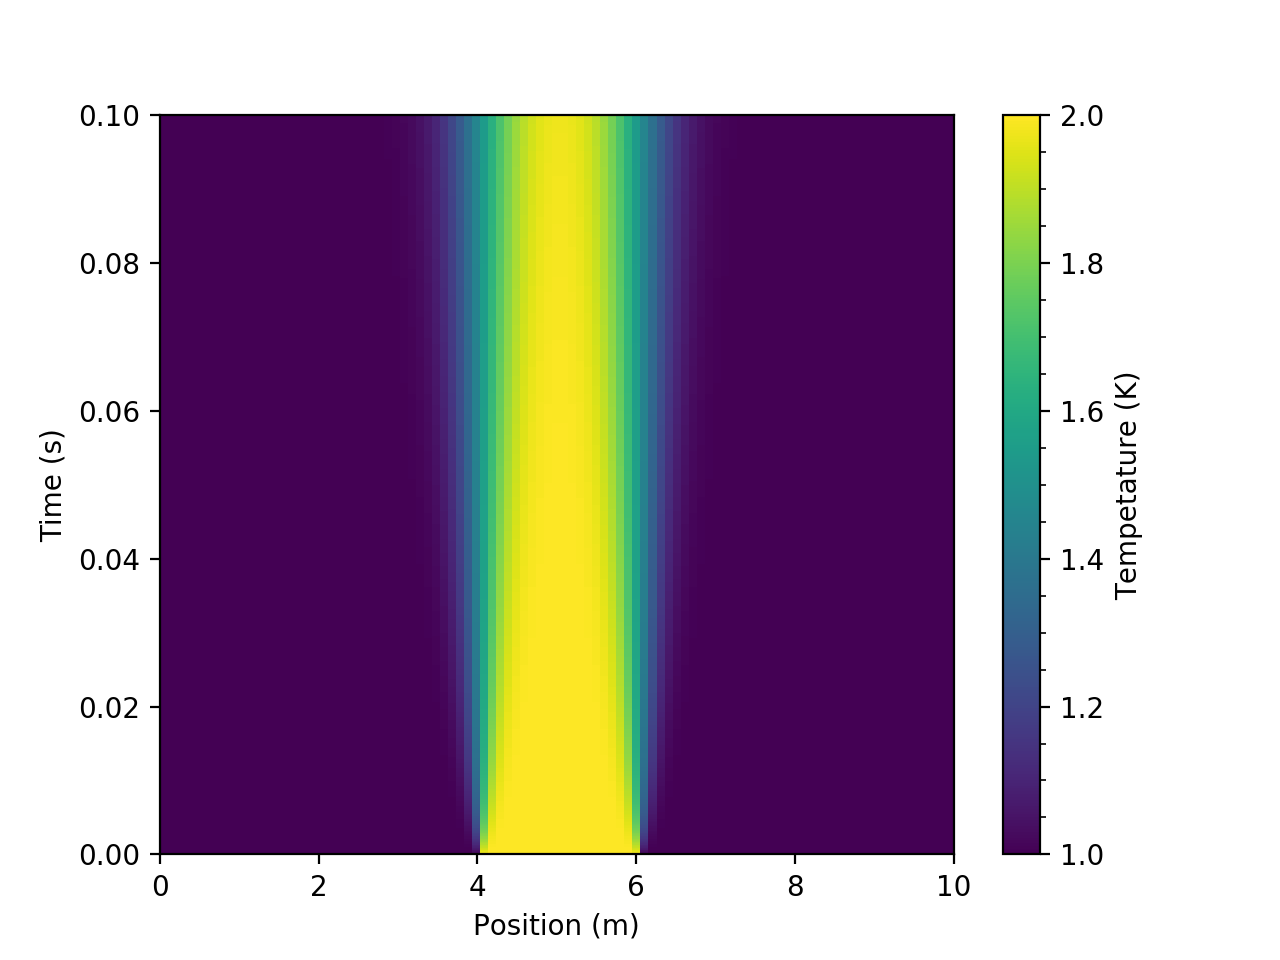

In [14]:
fig = plt.figure()
plt.pcolormesh(problem.x.points,problem.t,problem.solution)
plt.xlabel("Position (m)")
plt.ylabel("Time (s)")
cbar = plt.colorbar()
cbar.minorticks_on()
cbar.set_label("Tempetature (K)")
plt.show()

### What if we want to take a longer step?
When trying to solve PDEs with explicit methods, that is methods that march forwards in time we inevitably run into the issue of *instability*.
When the timestep becomes too long compared to the size of the spatial gridding (or select the wrong method to advance the equation) growing modes appear in the solution. These growing modes are not physical and very rapidly take over the solution and ruin your day. 

In [15]:
T0=np.ones(100)
T0[40:60]*=2.0
problem_unstable=HeatEquation(x=np.linspace(0,10,100),T_initial=T0)
problem_unstable.tau=0.0052
problem_unstable.solve(time_final=0.5)

<IPython.core.display.Javascript object>


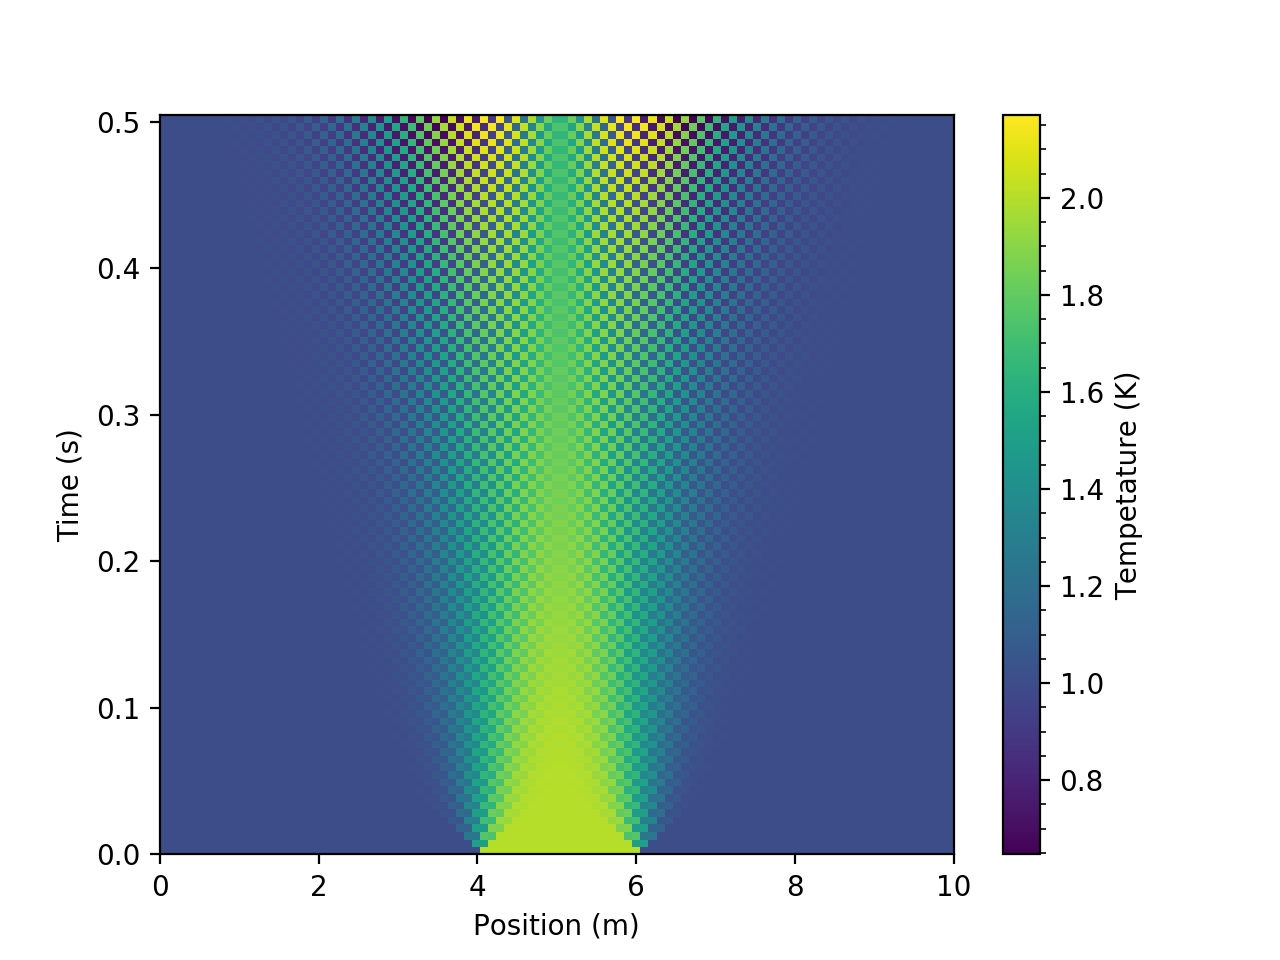

In [16]:
fig = plt.figure()
plt.pcolormesh(problem_unstable.x.points,problem_unstable.t,problem_unstable.solution)
plt.xlabel("Position (m)")
plt.ylabel("Time (s)")
cbar = plt.colorbar()
cbar.minorticks_on()
cbar.set_label("Tempetature (K)")
plt.show()

### The CFL
CFL stands for Courant–Friedrichs–Lewy condition. It is a criterion which if respected guarantees the timestep to not be unstable *under normal conditions*. This criterion varies depending on the equations you are solving, as well as the method you are using. Using central differences forward in time methods for the heat equation the CFL can be calculated to be 
\begin{equation}
\frac{\tau T_c}{h^2} \leq 0.5.
\end{equation}
So we can write a member function to fix the timestep to something very close to the CFL timestep 
```python
    def CFL(self):
        self.tau=0.5*(self.x.h**2)
        self.tau=self.tau/thermal_conductivity
        self.tau-=0.1*self.tau
    
    def solve(self, time_final=0.0):
        self.CFL()
        ...
```

In [17]:
class HeatEquation:
    def __init__(self,x,T_initial,time_start=0.0,thermal_conductivity=1.0):
        self.dt=self.heat_equation
        self.T=Field(T_initial)
        self.x=Coordinate(x)
        self.t=[time_start]
        self.tau=0
        self.solution=[self.T.get_field()]
        self.thermal_conductivity=thermal_conductivity
    
    def heat_equation(self):
        return self.thermal_conductivity*self.T.d_xx(self.x)

    def set_initial_conditions(self,T_initial,t0=0.0):
        self.T.set_field(T_initial)
    
    def evaluate_timestep(self):
        self.T.set_field(self.T.get_field()+self.tau*self.dt())
        
    def CFL(self):
        self.tau=0.5*(self.x.h**2)
        self.tau=self.tau/self.thermal_conductivity
        self.tau-=0.1*self.tau  
        
    def solve(self, time_final=0.0):
        self.CFL()
        while self.t[-1] < time_final:
            self.evaluate_timestep()
            self.solution.append(self.T.get_field())
            self.t.append(self.t[-1]+self.tau)
        self.solution=np.stack(self.solution, axis=0)

In [18]:
T0=np.ones(100)
T0[40:60]*=2.0
problem_unstable=HeatEquation(x=np.linspace(0,10,100),T_initial=T0)
problem_unstable.tau=0.0052
%timeit -n 1 -r 1 problem_unstable.solve(time_final=0.5)

2.85 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


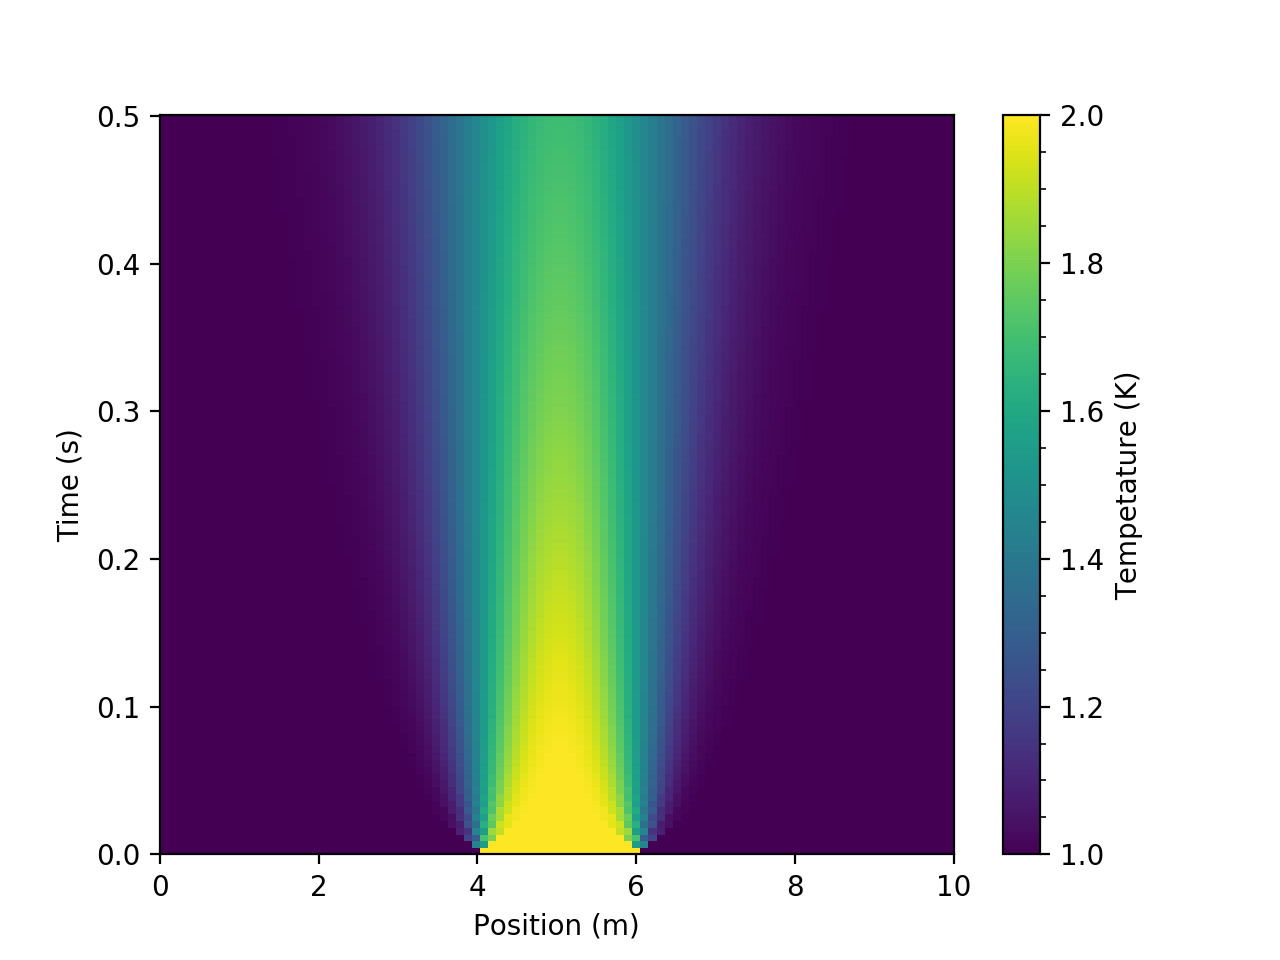

In [19]:
fig = plt.figure()
plt.pcolormesh(problem_unstable.x.points,problem_unstable.t,problem_unstable.solution)
plt.xlabel("Position (m)")
plt.ylabel("Time (s)")
cbar = plt.colorbar()
cbar.minorticks_on()
cbar.set_label("Tempetature (K)")
plt.show()

## Inheritance
To make our code more general we can use inheritance. Inheritance allows a class to inherit the attributes from a *parent* class in python referred to as ```super```.
For example, our HeatEquation class is some cind of PDE class, so we can define a generic PDE class that contains the methods and variables that pertain to parabolic/hyperbolic PDEs more in general, like the time derivative function and the solve function.
The HeatEquation class now no longer needs to define these itself as it can inherit them.
```python
class PDE:
    ...
class HeatEquation(PDE):
    ...
```
By default attributes are inherited by the child class, but it is still possible to overwrite them in the child by just redefining them.

As a sidenote, maybe the PDE class should be able to plot its solution. Lets implement that too!

In [20]:
class PDE:
    def __init__(self,x,y0,dt=None,time_initial=0.0):
        self.dt=dt
        self.f=Field(y0)
        self.x=Coordinate(x)
        self.t=[time_initial]
        self.tau=0
        self.solution=[self.f.y]
        self.time_initial=time_initial
        self.fieldName="y"
    
    def set_initial_conditions(self,y0,t0=0.0):
        self.f.set_field(y0)
    
    def timestep_euler(self):
        self.f.set_field(self.f.get_field()+self.tau*self.dt())
        
    def evaluate_timestep(self):
        self.timestep_euler()
        
    def CFL(self):
        pass
        
    def solve(self, time_final=0.0):
        while self.t[-1] < time_final:
            self.CFL()
            self.evaluate_timestep()
            self.solution.append(self.f.y)
            self.t.append(self.t[-1]+self.tau)
        self.solution=np.stack(self.solution, axis=0)
    
    def plot_full_solution(self,x_label="Position (m)",y_label="Time (s)"):
        fig = plt.figure()
        plt.pcolormesh(self.x.points,self.t,self.solution)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        cbar = plt.colorbar()
        cbar.minorticks_on()
        cbar.set_label(self.fieldName)

class HeatEquation(PDE):
    def __init__(self,x,T_initial,time_initial=0.0,thermal_conductivity=1.0):
        super().__init__(x=x,y0=T_initial,time_initial=time_initial,dt=self.heat_equation)
        self.thermal_conductivity=thermal_conductivity
        self.T=self.f
        self.fieldName="Temperature (K)"
    
    def heat_equation(self):
        return self.thermal_conductivity*self.T.d_xx(self.x)
    
    def CFL(self):
        self.tau=0.5*(self.x.h**2)
        self.tau=self.tau/self.thermal_conductivity
        self.tau-=0.1*self.tau 
        

In [21]:
T0=np.ones(100)
T0[40:60]*=2.0
problem_unstable=HeatEquation(x=np.linspace(0,10,100),T_initial=T0)
problem_unstable.tau=0.0052
problem_unstable.solve(time_final=0.5)

<IPython.core.display.Javascript object>


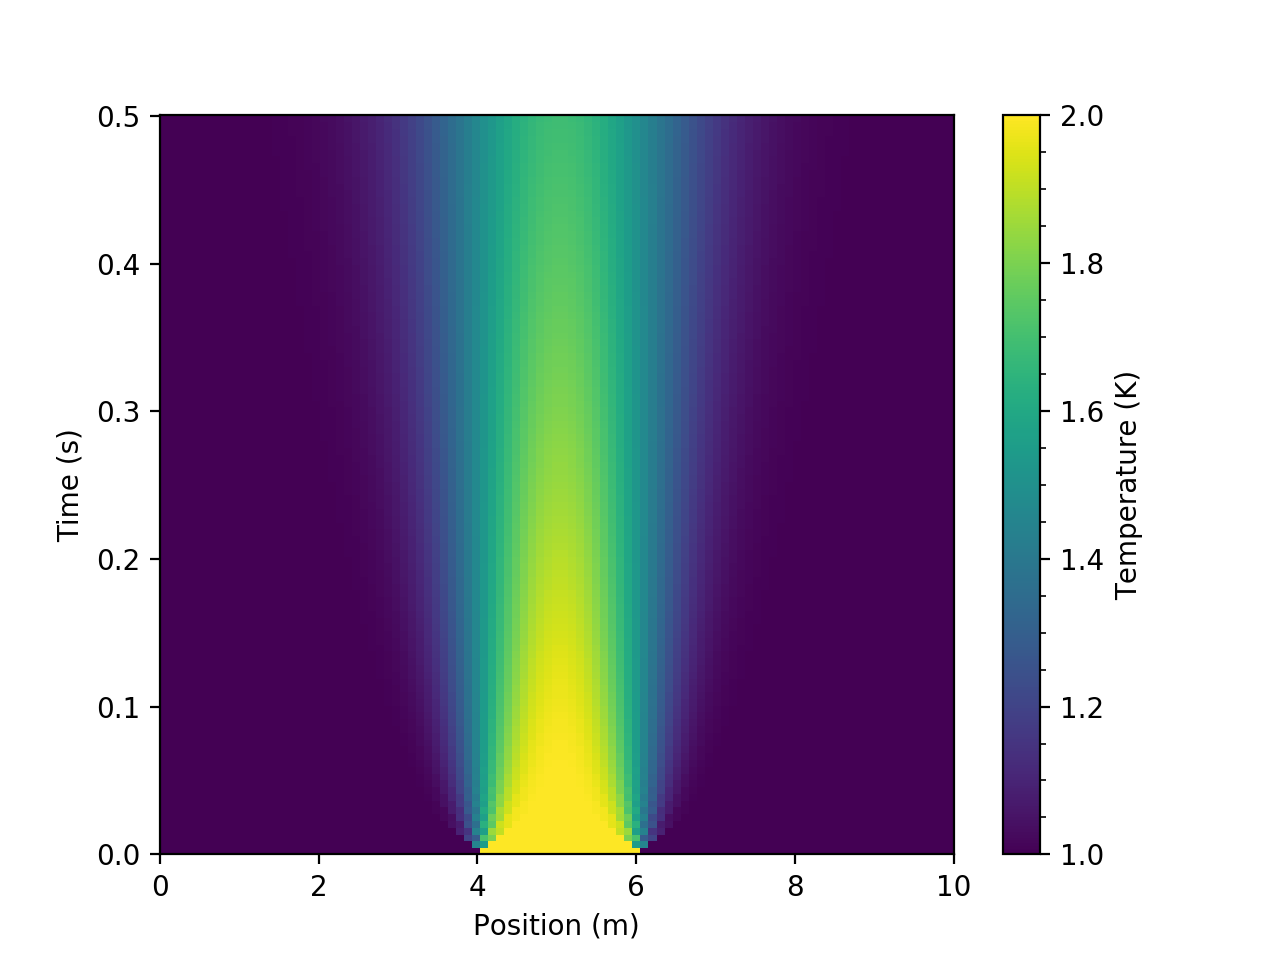

In [22]:
problem_unstable.plot_full_solution()

### Putting it to the test
With the parent PDE class it is much easier to expand the code to solve more equations, lets take for example: 

\begin{equation}
\partial_t T=c_s T \partial_x T + T_c\partial_x^2 T
\end{equation}

By defining a new child class of PDE it only takes a few lines of code to have a working solver for the new PDE.

In [23]:
class HeatConductionConvectionEquation(PDE):
    def __init__(self,x,T_initial,time_initial=0.0,thermal_conductivity=1.0,cs=1.0):
        super().__init__(x=x,y0=T_initial,time_initial=time_initial,dt=self.heat_equation)
        self.thermal_conductivity=thermal_conductivity
        self.T=self.f
        self.cs=cs
        self.fieldName="Temperature (K)"
    
    def heat_equation(self):
        return self.T.get_field()*self.cs*self.T.d_x(self.x)+self.thermal_conductivity*self.T.d_xx(self.x)
    
    def CFL(self):
        self.tau=0.5*(self.x.h**2)
        self.tau=self.tau/self.thermal_conductivity
        self.tau-=0.1*self.tau 
         

In [24]:
T0=np.ones(100)
T0[40:60]*=2.0
problem_conv=HeatConductionConvectionEquation(x=np.linspace(0,10,100),T_initial=T0,cs=5.0)
problem_conv.tau=0.0052
%timeit -n 1 -r 1 problem_conv.solve(time_final=0.5)

4.45 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


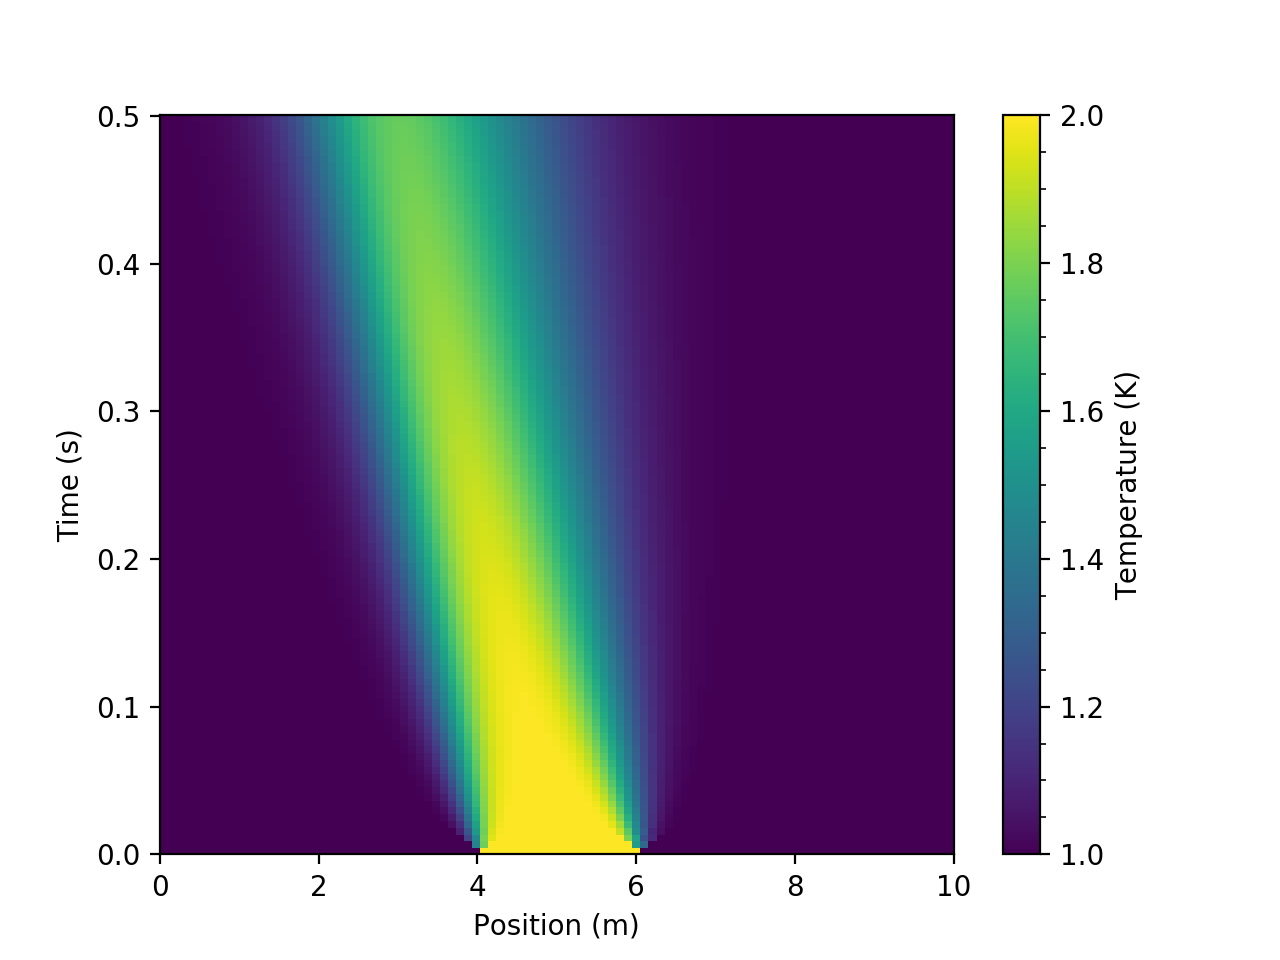

In [25]:
problem_conv.plot_full_solution()

## Packaging it all up

Collected below is the final version of the code we wrote, but what if we wanted to use this code in multiple scripts or notebooks? 

In [28]:
class Coordinate:
    def __init__(self,points):
        self.points=points
        self.h=points[1]-points[0]

class Field:
    def __init__(self,f):
        self.y=f

    def set_field(self,new_field):
        self.y=new_field
    
    def get_field(self):
        return self.y
    
    def d_x(self,coordinate):
        '''
        takes the first derivative of self with respect to a Coordinate type variable.
        '''
        return np.concatenate((np.array([0.0]),(1.0/(2*coordinate.h))*(self.y[1:-1]-self.y[:-2]),np.array([0.0])))
    
    def d_xx(self,coordinate):
        return np.concatenate((np.array([0.0]),(1.0/(coordinate.h**2))*(self.y[2:]-2.0*self.y[1:-1]+self.y[:-2]),np.array([0.0])))

class PDE:
    '''
    A generic parabolic/hyperbolic class. Can be used as a parent class for specialised PDE solvers.
    
    Member variables:
    PDE.x -> The coordinate system on which the PDE is set up (type: Coordinate)
    PDE.f -> The field the PDE is advancing (type: Field)
    PDE.t -> Stores the point in time at which each step of the solution is at (type: [])
    PDE.solution -> Stores the solution to the PDE in time (type: [np.array])
    PDE.dt -> The time derivative function that defines the PDE (type: function)
    PDE.time_initial -> The time coordinate of the initial conditions
    PDE.tau -> The timestep size
    PDE.fieldName -> Name of the field, used for plotting (type: string)
    
    Member functions:
    PDE.set_initial_conditions(self,y0,t0=0.0) -> reset the initial conditions
    PDE.timestep_euler(self) -> forward Euler timestep method
    PDE.timestep(self) -> the timestepping method used inthe solver, forward Euler by default
    PDE.CFL(self) -> placeholder function for the CFL timestep calculator
    PDE.solve(self, time_final=0.0) -> advances the PDE by taking CFL steps until time_final is reached
    PDE.plot_full_solution(self,x_label="Position (m)",y_label="Time (s)") -> plots the solution
    '''
    def __init__(self,x,y0,dt=None,time_initial=0.0):
        self.dt=dt
        self.f=Field(y0)
        self.x=Coordinate(x)
        self.t=[time_initial]
        self.tau=0
        self.solution=[self.f.y]
        self.time_initial=time_initial
        self.fieldName="y"
    
    def set_initial_conditions(self,y0,t0=0.0):
        self.f.set_field(y0)
    
    def timestep_euler(self):
        self.f.set_field(self.f.get_field()+self.tau*self.dt())
        
    def evaluate_timestep(self):
        self.timestep_euler()
        
    def CFL(self):
        pass
        
    def solve(self, time_final=0.0):
        while self.t[-1] < time_final:
            self.CFL()
            self.evaluate_timestep()
            self.solution.append(self.f.y)
            self.t.append(self.t[-1]+self.tau)
        self.solution=np.stack(self.solution, axis=0)
    
    def plot_full_solution(self,x_label="Position (m)",y_label="Time (s)"):
        fig = plt.figure()
        plt.pcolormesh(self.x.points,self.t,self.solution)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        cbar = plt.colorbar()
        cbar.minorticks_on()
        cbar.set_label(self.fieldName)

class HeatEquation(PDE):
    def __init__(self,x,T_initial,time_initial=0.0,thermal_conductivity=1.0):
        super().__init__(x=x,y0=T_initial,time_initial=time_initial,dt=self.heat_equation)
        self.thermal_conductivity=thermal_conductivity
        self.T=self.f
        self.fieldName="Temperature (K)"
    
    def heat_equation(self):
        return self.thermal_conductivity*self.T.d_xx(self.x)
    
    def CFL(self):
        self.tau=0.5*(self.x.h**2)
        self.tau=self.tau/self.thermal_conductivity
        self.tau-=0.1*self.tau 
        
class HeatConductionConvectionEquation(PDE):
    def __init__(self,x,T_initial,time_initial=0.0,thermal_conductivity=1.0,cs=1.0):
        super().__init__(x=x,y0=T_initial,time_initial=time_initial,dt=self.heat_equation)
        self.thermal_conductivity=thermal_conductivity
        self.T=self.f
        self.cs=cs
        self.fieldName="Temperature (K)"
    
    def heat_equation(self):
        return self.T.get_field()*self.cs*self.T.d_x(self.x)+self.thermal_conductivity*self.T.d_xx(self.x)
    
    def CFL(self):
        self.tau=0.5*(self.x.h**2)
        self.tau=self.tau/self.thermal_conductivity
        self.tau-=0.1*self.tau 

By placing the classes we wrote in a ```.py``` file, we can then access all the contained code by importing it. This reduces the need to copy the same code around when doing similar things and overall makes everything neater.
```python
import PDEs as pde
```
the same way as we do for packages like numpy. In our case though we have to be careful that our ```.py``` file is in the same directory (otherwise we have to specify where python can find it).

#### Docstrings
It is possible to make your code document itself by adding docstrings to classes and functions.
```python
def function_to_document():
    '''
    docstring
    '''
    code ...
```
These docstrings will be shown when 
```python
? Thing.I.dont.know
```
is called in a cell or in the python terminal.

In [29]:
import PDEs as pde
pde = reload(pde)

In [30]:
?pde.PDE

In [31]:
?pde.Field.d_x

In [32]:
T0=np.ones(100)
T0[40:60]*=2.0
problem_conv=pde.HeatConductionConvectionEquation(x=np.linspace(0,10,100),T_initial=T0,cs=5.0)
problem_conv.tau=0.0052
%timeit -n 1 -r 1 problem_conv.solve(time_final=0.5)

5.04 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


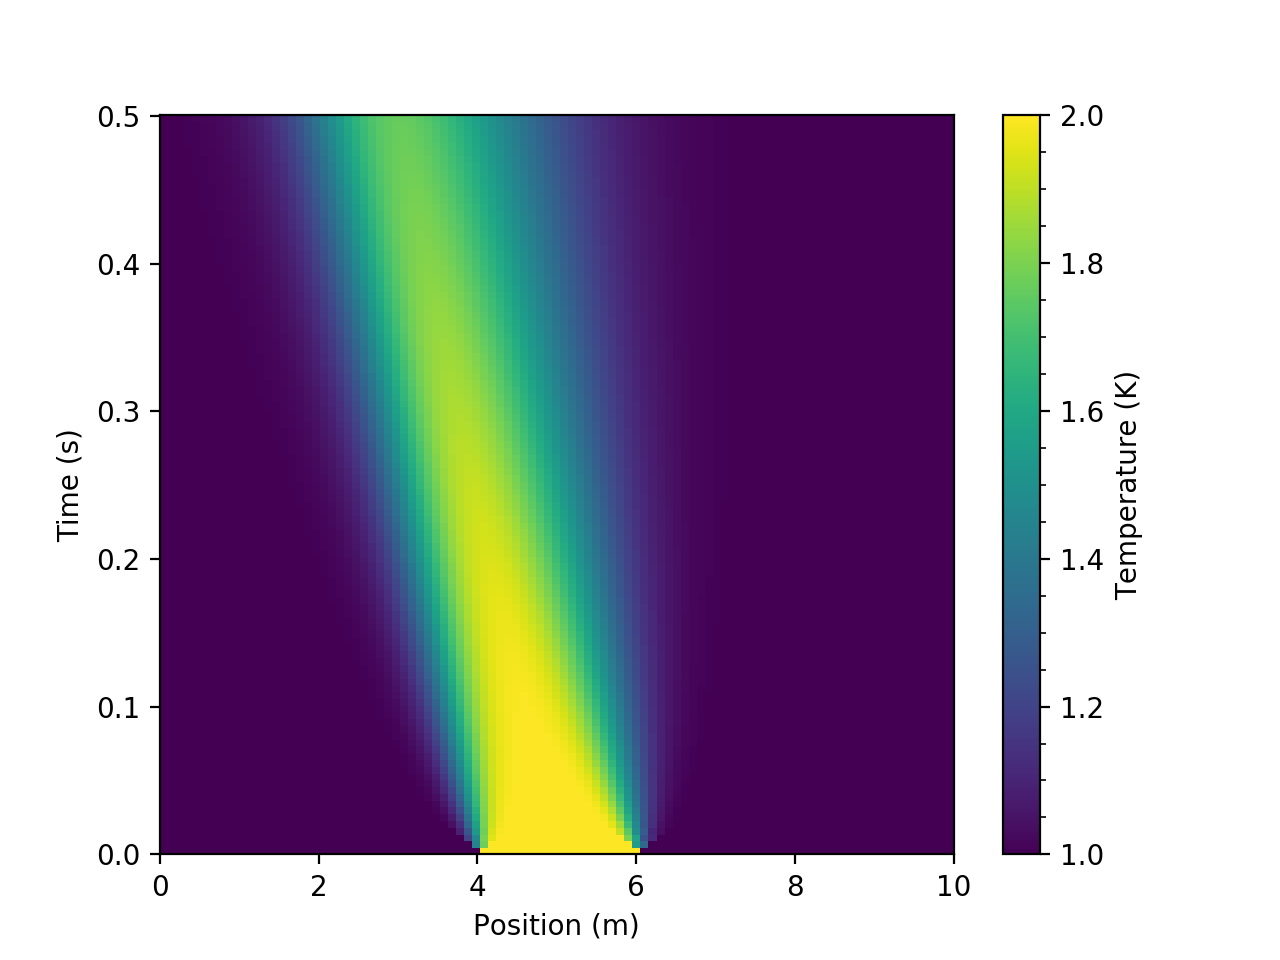

In [33]:
problem_conv.plot_full_solution()